### Libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Personal Implementation of Morphological Operators

Here, we will define basic mathematical morphology operations which are **erosion and dilation**, used for **noise removal in an image**, and **the convolution operation** for image filtering.

# Reminder:
- `Erosion`: helps **separate objects** that are stuck together or **remove protrusions or rough areas** in an image while **decreasing the size of objects**.

<div style="display: flex;" >  
  <div style="width:30%; margin:auto;">
    <img src="https://user.oc-static.com/upload/2018/11/13/15421162165439_erosion.png" style="width:100%">
    <figcaption style="text-align: center; margin-top:10px">Erosion: Separation of objects</figcaption>
  </div>
  <div style="width:30%; margin:auto;">
    <img src="https://user.oc-static.com/upload/2018/11/13/15421163330083_extrusion.png" style="width:100%">
    <figcaption style="text-align: center; margin-top:10px">Erosion: Removal of protrusions</figcaption>
  </div>
</div>

#

- `Dilation`: is a process that helps **repair interrupted lines** in an image or **fill intrusions (or holes)** in an image while **increasing the size of objects**.

<div style="display: flex;" >  
  <div style="width:30%; margin:auto;">
    <img src="https://user.oc-static.com/upload/2018/11/13/15421164189975_dilatation%20ill%201.png" style="width:100%">
    <figcaption style="text-align: center; margin-top:10px">Dilation: Discontinuity to continuity</figcaption>
  </div>
  <div style="width:30%; margin:auto;">
    <img src="https://user.oc-static.com/upload/2018/11/13/15421164513282_dilatation%20ill%202.png" style="width:100%">
    <figcaption style="text-align: center; margin-top:10px">Dilation: Filling in holes</figcaption>
  </div>
</div>


In [2]:
# convolution function
def convolution(image, kernel, function):
    new_image = np.zeros(image.shape,np.uint8)
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            new_image[i,j] = function(image,i,j,kernel)
    return new_image

# calculate the value of a pixel in dilation
def pixel_dilation(image, line, column, kernel):
    width = kernel.shape[0] // 2
    height = kernel.shape[1] // 2
    pixel_value = False;
    for i in range(0, kernel.shape[0]):
        for j in range(0,kernel.shape[1]):
            x_image = line + i - width
            y_image = column + j - height
            if ((x_image >= 0) and (x_image < image.shape[0]) and
                (y_image>=0) and (y_image<image.shape[1])):
                # key line for dilation: 
                if(image[x_image,y_image] and kernel[i,j]):
                    return True #Pour accélerer
    return pixel_value


# calculate the value of a pixel in erosion
def pixel_erosion(image, line, column, kernel):
    width = kernel.shape[0] // 2
    height = kernel.shape[1] // 2
    pixel_value = True;
    for i in range(0,kernel.shape[0]):
        for j in range(0,kernel.shape[1]):
            x_image = line + i - width
            y_image = column + j - height
            if((x_image >= 0) and (x_image < image.shape[0]) and
               (y_image>=0) and (y_image<image.shape[1])):
                # key line for dilation:  
                if (kernel[i,j] and not(image[x_image,y_image])):
                    return False
    return pixel_value


### Data import

In [3]:
amazon_2000 = cv.imread("../IMAGES/amazon_2000.png")
amazon_2012 = cv.imread("../IMAGES/amazon_2012.png")

### Plot image in RGB

    I use image[...,::-1] to reverse openCV BGR's native channels to RGB

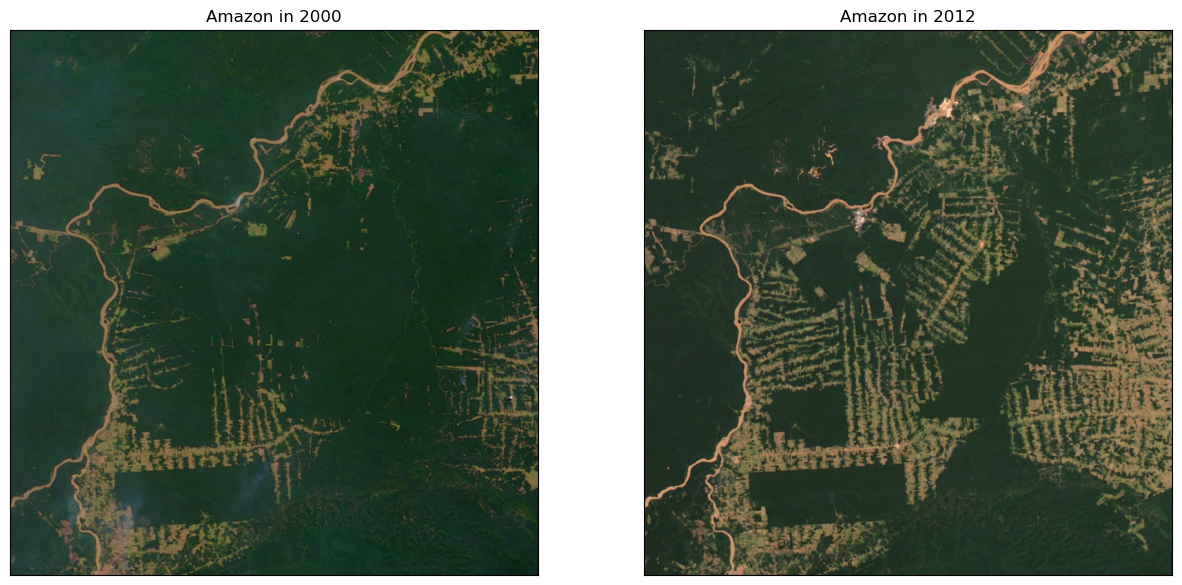

In [4]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(amazon_2000[...,::-1], cmap = "gray")
plt.title('Amazon in 2000')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(amazon_2012[...,::-1], cmap = "gray")
plt.title('Amazon in 2012')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.show()

### Data preprocessing

### Binarization for Forest Quantification

The current format poses challenges in quantifying forested and non-forested areas. To address this, image binarization becomes more relevant. In this approach, assigning 
- 1 to the pixel intensity of deforested zones and 
- 0 to the rest is proposed.

The **OTSU** method is chosen for this binarization due to its suitability with the images' characteristics. OTSU's effectiveness relies on the assumption that the algorithm performs best when the image consists of only two planes. In our scenario, these planes represent the foreground (non-deforested areas) and the background (deforested zones).


In [5]:
# Convert image to grayscale
gray_amazon_2000, gray_amazon_2012 = cv.cvtColor(amazon_2000, cv.COLOR_BGR2GRAY) , cv.cvtColor(amazon_2012, cv.COLOR_BGR2GRAY)

# Apply the Otsu method for binarization
_, binary_amazon_2000 = cv.threshold(gray_amazon_2000, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
_, binary_amazon_2012 = cv.threshold(gray_amazon_2012, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# (normalization) make values 0 or 1
binary_amazon_2000 = binary_amazon_2000 / 255 
binary_amazon_2012 = binary_amazon_2012 / 255

# different pixel values in images
np.unique(binary_amazon_2000), np.unique(binary_amazon_2012)

(array([0., 1.]), array([0., 1.]))

#### Plot images binary

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(binary_amazon_2000, cmap = "gray")
plt.title('Amazon in 2000 binary')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(binary_amazon_2012, cmap = "gray")
plt.title('Amazon in 2012 binary')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.show()

### Noise Reduction for Improved Deforestation Analysis

We've observed that the results are reasonably satisfactory. However, our images do not adequately represent reality for accurate deforestation quantification. In reality, deforested areas tend to span continuously. There's noise introduced not only due to image quality (high-altitude satellite imagery) but also as a result of the binarization process we applied.

# 
### Noise Reduction

To address this, we'll use the mathematical morphological operation of **closing (dilation followed by erosion)** to eliminate noise. This is because we aim to obtain continuous deforested zones.

**This operation helps remove small holes while preserving the overall shape and size of the areas.**

# 
### Filter Selection
We will use multiple filters with varying sizes to determine the one that best reduces noise in our images.

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


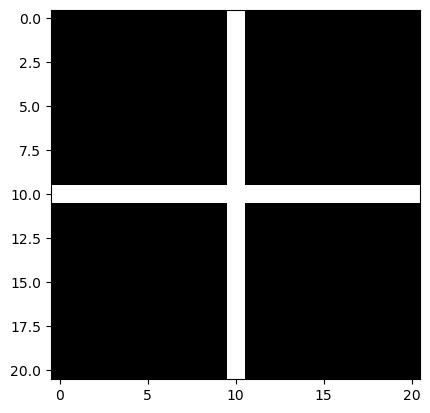

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


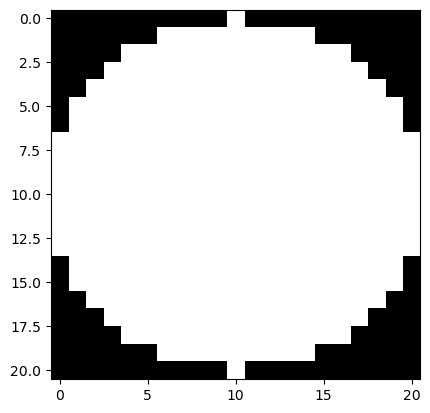

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


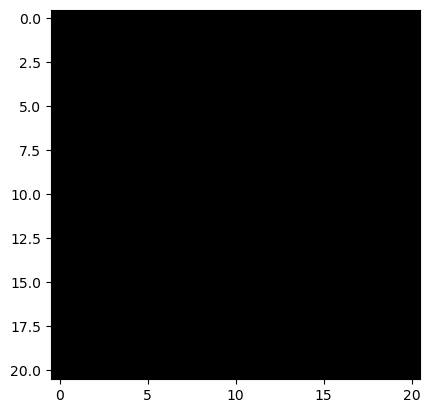

In [7]:
kernel_cross = cv.getStructuringElement(cv.MORPH_CROSS,(21,21))
print(kernel_cross)
plt.imshow(kernel_cross,cmap='gray')
plt.show()

kernel_circle = cv.getStructuringElement(cv.MORPH_ELLIPSE,(21,21))
print(kernel_circle)
plt.figure()
plt.imshow(kernel_circle, cmap='gray')
plt.show()

kernel_rect = cv.getStructuringElement(cv.MORPH_RECT,(21,21))
print(kernel_rect)
plt.figure()
plt.imshow(kernel_rect, cmap='gray')
plt.show()

kernels = {
    "cross": kernel_cross,
    "circle": kernel_circle,
    "rect": kernel_rect
}



### Closure Filtering

1. 2000 Image Filtering 

Kernel CROSS | Size: 21X21


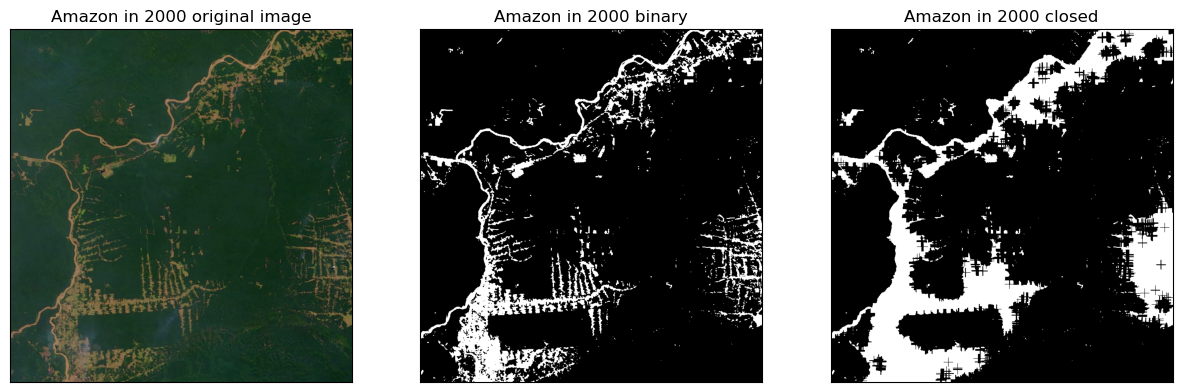



Kernel CIRCLE | Size: 21X21


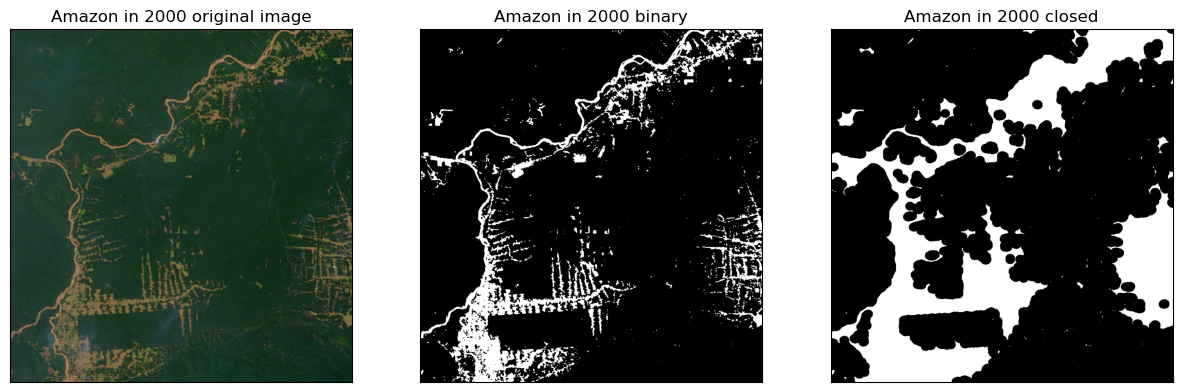



Kernel RECT | Size: 21X21


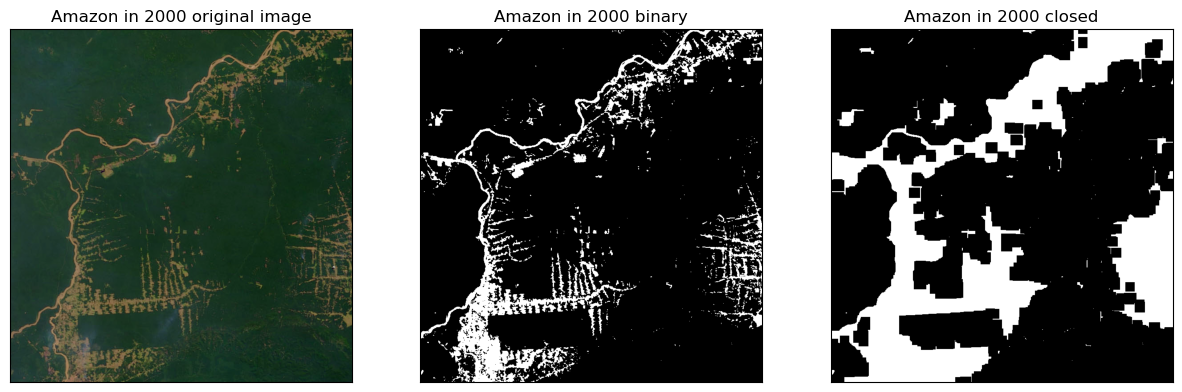

In [8]:
# Dictionarie to store 2000 filtered image 
closed_images_2000 = {}

# Iterating through the kernels
for k, v in kernels.items():
    kernel = v
    
    # First dilation
    dilation_image = convolution(binary_amazon_2000, kernel, pixel_dilation)
    
    # Second erosion
    closed_amazon_2000 = convolution(dilation_image, kernel, pixel_erosion)
    
    # Saving the filtered image
    closed_images_2000[k] = closed_amazon_2000
    
    # Plotting the images
    print(f"Kernel {k.upper()} | Size: {v.shape[0]}X{v.shape[1]}")
    plt.figure(figsize=(15, 10))
    
    # Original image in 2000
    plt.subplot(1, 3, 1)
    plt.imshow(amazon_2000[...,::-1], cmap="gray")
    plt.title('Amazon in 2000 original image')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    # Binary image in 2000
    plt.subplot(1, 3, 2)
    plt.imshow(binary_amazon_2000, cmap="gray")
    plt.title('Amazon in 2000 binary')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])

    # Filtered image in 2000
    plt.subplot(1, 3, 3)
    plt.imshow(closed_amazon_2000, cmap="gray")
    plt.title('Amazon in 2000 closed')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    print("\n")


1. 2012 Image Filtering 

Kernel CROSS | Size: 21X21


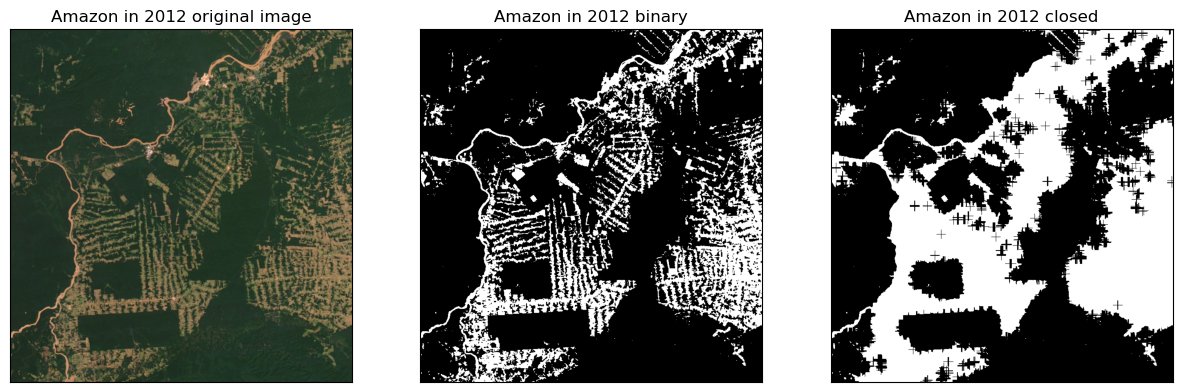



Kernel CIRCLE | Size: 21X21


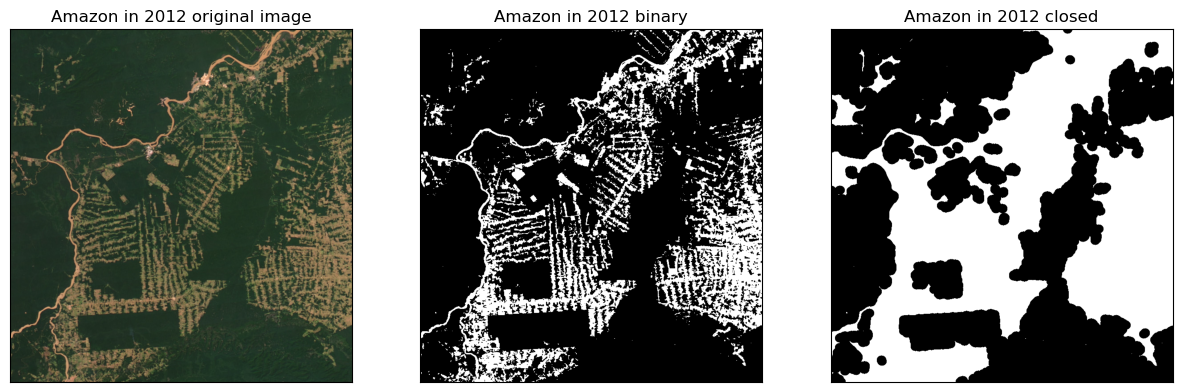



Kernel RECT | Size: 21X21


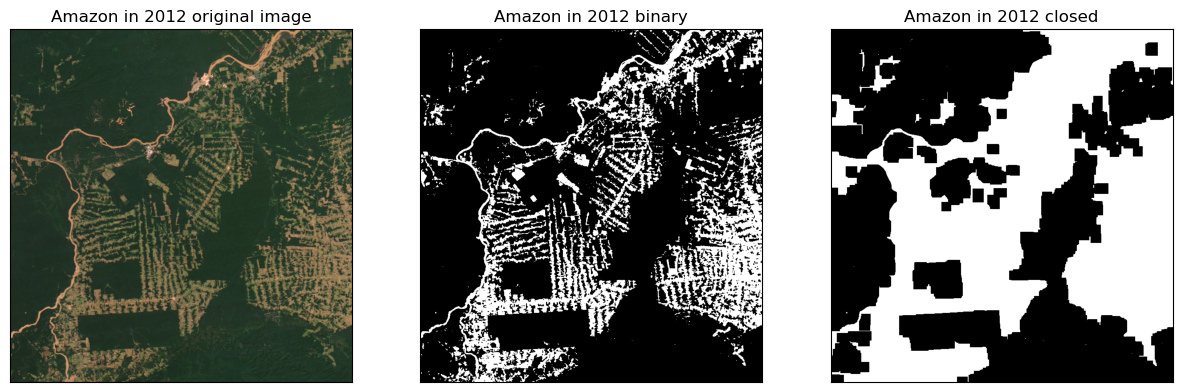

In [9]:
# Dictionary to store 2012 filtered images
closed_images_2012 = {}

for k, v in kernels.items():
    kernel = v
    
    # Applying morphological operations to filter the 2012 image
    close_amazon_2012 = convolution(convolution(binary_amazon_2012, kernel, pixel_dilation), kernel, pixel_erosion)
    closed_images_2012[k] = close_amazon_2012
    
    # Displaying the filtered images
    print(f"Kernel {k.upper()} | Size: {v.shape[0]}X{v.shape[1]}")
    plt.figure(figsize=(15, 10))
    
    # Original image in 2012
    plt.subplot(1, 3, 1)
    plt.imshow(amazon_2012[...,::-1], cmap="gray")
    plt.title('Amazon in 2012 original image')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    # Binary image in 2012
    plt.subplot(1, 3, 2)
    plt.imshow(binary_amazon_2012, cmap="gray")
    plt.title('Amazon in 2012 binary')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])

    # Filtered image in 2012
    plt.subplot(1, 3, 3)
    plt.imshow(close_amazon_2012, cmap="gray")
    plt.title('Amazon in 2012 closed')
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    print("\n")


We've observed that the most suitable filter for our issue is the `kernel_circle`. Hence, we will use the images filtered by this kernel for deforestation quantification.

### Recovery of the additional deforestation between 2000 and 2012

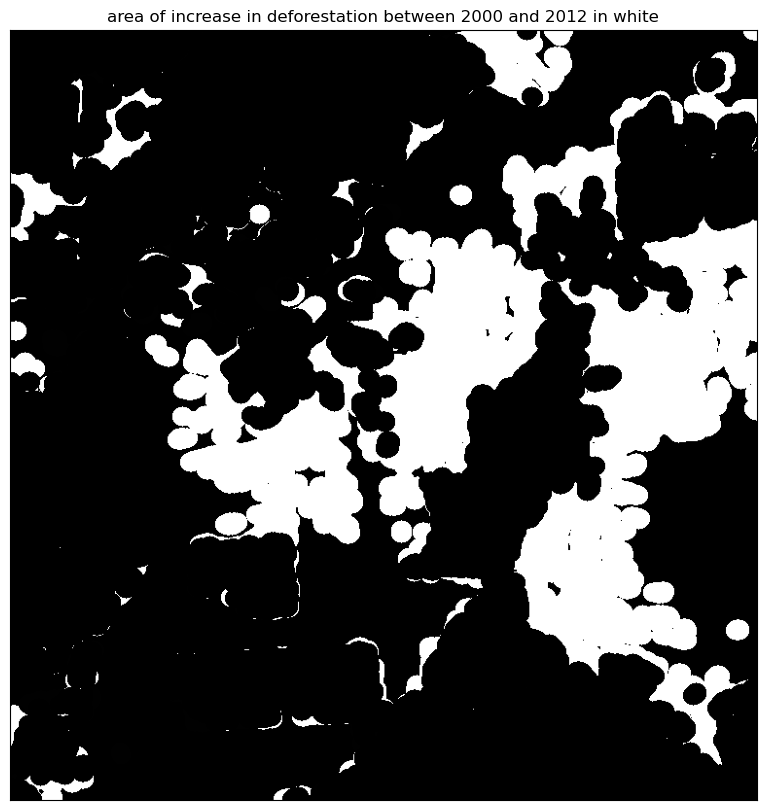

In [10]:
# différence 
qtt_deforst_btwn_2000_2012 = (closed_images_2000["circle"] - closed_images_2012["circle"])/255  # normalized image

# plotting  difference
plt.figure(figsize=(15, 10))    
plt.imshow(qtt_deforst_btwn_2000_2012, cmap = "gray")
plt.title('area of increase in deforestation between 2000 and 2012 in white')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.show()

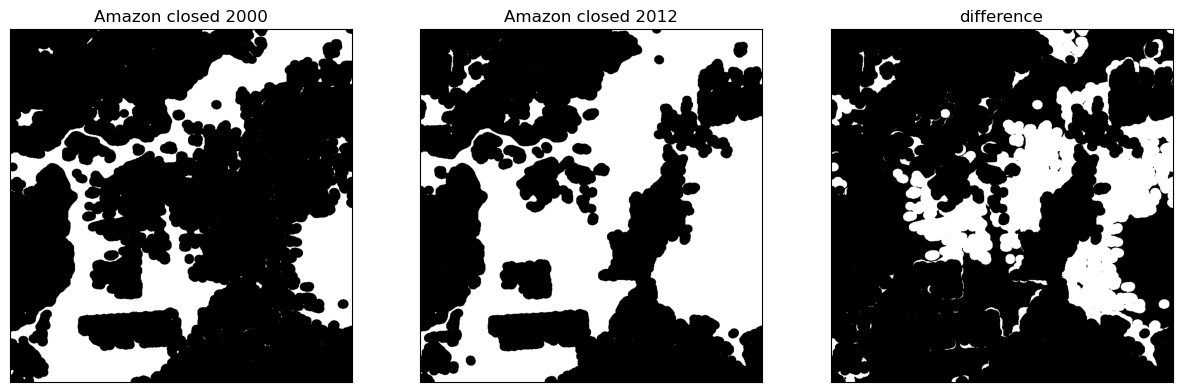

In [11]:
plt.figure(figsize=(15, 10))
    
plt.subplot(1, 3, 1)
plt.imshow(closed_images_2000["circle"], cmap = "gray")
plt.title('Amazon closed 2000')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(closed_images_2012["circle"], cmap = "gray")
plt.title('Amazon closed 2012')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(qtt_deforst_btwn_2000_2012, cmap = "gray")
plt.title('difference')
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.show()
print("\n")

### Rate

In [12]:
# calculate
p_2000 = np.sum(closed_images_2000["circle"])/closed_images_2000["circle"].size*100
p_2012 = np.sum(closed_images_2012["circle"])/closed_images_2012["circle"].size*100
p_2000_2012 = p_2012 - p_2000

# print result
print(f"Percentage of deforested areas in 2000: {p_2000:.2f}%")
print(f"Percentage of deforested areas in 2000: {p_2012:.2f}%")
print(f"Percentage of deforested areas in 2000: {p_2000_2012:.2f}%")

Percentage of deforested areas in 2000: 25.13%
Percentage of deforested areas in 2000: 46.46%
Percentage of deforested areas in 2000: 21.33%
